# GAB
## Metodologias de entrenamiento

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf    

# Directorio de trabajo
# os.chdir('')

# Datos privados
# Pueden solicitarse de forma privada
# datos = pd.read_csv()

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import median_absolute_error, mean_squared_error,  max_error

import matplotlib.pyplot as plt


In [2]:
# Hago encoding de temporales:
def Enc_temp(df,temporales):
    # Ordenar valores
    df = df.sort_index(ascending=True)

    # Hacer el encoding de las temporales
    for i,col in enumerate(temporales):
        df[col+'_'+"sin"] = np.sin(2 * np.pi * df[col]/df[col].max())
        df[col+'_'+"cos"] = np.cos(2 * np.pi * df[col]/df[col].max())    
    return(df)

datos = Enc_temp(datos,["mes","dia","hora","dia_mes","estacion"])
print("Shape datos encoding temporales:",datos.shape)

# Dividio en X e y
X = datos.drop(["PM25"],axis=1)
y = datos[["PM25"]]
print("Shape X:",X.shape)
print("Shape y:",y.shape)

# Modelo de alerta
# Lag N
N = 120
y = y.iloc[N-1:].copy() 
print("Shape y_lag:",y.shape)
X = X.iloc[:-(N-1)].copy() 
print("Shape X_lag:",X.shape)

Shape datos encoding temporales: (10152, 77)
Shape X: (10152, 76)
Shape y: (10152, 1)
Shape y_lag: (10033, 1)
Shape X_lag: (10033, 76)


In [3]:
results = pd.DataFrame(columns = ['Modelo', 'median_absolute_error',"mean_squared_error","root_mean_squared_error","max_error"])

# Stratified split

In [4]:
# Divido entrenamiento y testeo pero estratificado, para eso creo el id
X['mes_dia'] = X['mes'].astype(str) + X['dia'].astype(str)

# Para el de alerta 1996 permitia obtener el anterior resultado.
X_training, X_test1, y_training, y_test1 = train_test_split(X, y, test_size=0.1, random_state=2474, stratify=X[['mes_dia']])
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1, random_state=2474, stratify=X_training[['mes_dia']])

X_train = X_train.drop(["mes_dia"],axis=1)
X_test1 = X_test1.drop(["mes_dia"],axis=1)
X_val = X_val.drop(["mes_dia"],axis=1)
X = X.drop(["mes_dia"],axis=1)

X_train = X_train.sort_index(ascending=True)
X_test1 = X_test1.sort_index(ascending=True)
y_train = y_train.sort_index(ascending=True)
y_test1 = y_test1.sort_index(ascending=True)
X_val = X_val.sort_index(ascending=True)
y_val = y_val.sort_index(ascending=True)

print("Shape X train",X_train.shape)
print("Shape y train",y_train.shape)
print("Shape X test",X_test1.shape)
print("Shape y test",y_test1.shape)
print("Shape X val",X_val.shape)
print("Shape y val",y_val.shape)

Shape X train (8126, 76)
Shape y train (8126, 1)
Shape X test (1004, 76)
Shape y test (1004, 1)
Shape X val (903, 76)
Shape y val (903, 1)


In [6]:
columns_x = list(X_train.columns)
scaler_x = StandardScaler()
X_train_std = X_train.copy()
X_train_std[columns_x] = scaler_x.fit_transform(X_train[columns_x])
X_test1_std = X_test1.copy()
X_test1_std[columns_x] = scaler_x.transform(X_test1[columns_x])
X_val_std = X_val.copy()
X_val_std[columns_x] = scaler_x.transform(X_val[columns_x])

columns_y = list(y_train.columns)
scaler_y = StandardScaler()
y_train_std = y_train.copy()
y_train_std[columns_y] = scaler_y.fit_transform(y_train[columns_y])
y_test1_std = y_test1.copy()
y_test1_std[columns_y] = scaler_y.transform(y_test1[columns_y])
y_val_std = y_val.copy()
y_val_std[columns_y] = scaler_y.transform(y_val[columns_y])

In [7]:
# reshape input to be 3D [samples, timesteps, features]
X_train_red = X_train_std.to_numpy().reshape((X_train_std.shape[0], 1, X_train_std.shape[1]))
X_test1_red = X_test1_std.to_numpy().reshape((X_test1_std.shape[0], 1, X_test1_std.shape[1]))
X_val_red = X_val_std.to_numpy().reshape((X_val_std.shape[0], 1, X_val_std.shape[1]))

y_train_red=y_train_std.to_numpy()
y_test1_red = y_test1_std.to_numpy()
y_val_red=y_val_std.to_numpy()
print(X_train_red.shape, y_train_red.shape, X_test1_red.shape, y_test1_red.shape,X_val_red.shape,y_val_red.shape)

(8126, 1, 76) (8126, 1) (1004, 1, 76) (1004, 1) (903, 1, 76) (903, 1)


In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30,restore_best_weights=True)

# Modelo
regressor = Sequential()
regressor.add(LSTM(units = 200, return_sequences = True,  input_shape=(X_train_red.shape[1], X_train_red.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = keras.optimizers.Adam(1e-3), loss = 'mean_squared_error', 
                  metrics = ['mean_squared_error'])

history2 = regressor.fit(X_train_red, y_train_red, epochs=300, batch_size=64, validation_data=(X_val_red, y_val_red), verbose=2, shuffle=False, callbacks=[es])

Epoch 1/300
127/127 - 7s - loss: 0.9153 - mean_squared_error: 0.9153 - val_loss: 0.8402 - val_mean_squared_error: 0.8402 - 7s/epoch - 57ms/step
Epoch 2/300
127/127 - 2s - loss: 0.7503 - mean_squared_error: 0.7503 - val_loss: 0.7804 - val_mean_squared_error: 0.7804 - 2s/epoch - 14ms/step
Epoch 3/300
127/127 - 2s - loss: 0.7041 - mean_squared_error: 0.7041 - val_loss: 0.7099 - val_mean_squared_error: 0.7099 - 2s/epoch - 13ms/step
Epoch 4/300
127/127 - 2s - loss: 0.6627 - mean_squared_error: 0.6627 - val_loss: 0.6648 - val_mean_squared_error: 0.6648 - 2s/epoch - 12ms/step
Epoch 5/300
127/127 - 1s - loss: 0.6304 - mean_squared_error: 0.6304 - val_loss: 0.6357 - val_mean_squared_error: 0.6357 - 1s/epoch - 11ms/step
Epoch 6/300
127/127 - 1s - loss: 0.5891 - mean_squared_error: 0.5891 - val_loss: 0.6203 - val_mean_squared_error: 0.6203 - 1s/epoch - 11ms/step
Epoch 7/300
127/127 - 1s - loss: 0.5575 - mean_squared_error: 0.5575 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 1s/epoch - 9m

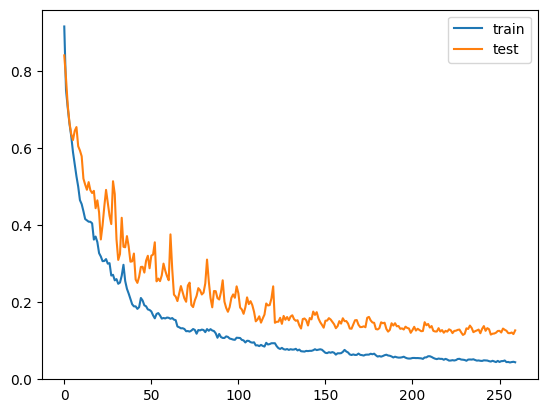

In [9]:
# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

history_df = pd.DataFrame({'train_loss':history2.history['loss'], 'val_loss':history2.history['val_loss']})
history_df.to_csv("history_stratified_gab.csv")

In [10]:
# make a prediction
yhat = regressor.predict(X_test1_red)
# # invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]
# # # invert scaling for actual
test_y = y_test1_red.reshape((len(y_test1_red), 1))
inv_y = scaler_y.inverse_transform(test_y)
inv_y = inv_y[:,0]

resultado_parcial = {"Modelo":"LSTM_StratifiedSplit",
"median_absolute_error":median_absolute_error(inv_y,inv_yhat),
"mean_squared_error":mean_squared_error(inv_y,inv_yhat, squared=True),
"root_mean_squared_error":mean_squared_error(inv_y,inv_yhat, squared=False),
"max_error":max_error(inv_y,inv_yhat)
}

results=results.append(resultado_parcial, 
            ignore_index = True)

results.head()

32/32 [==============================] - 1s 2ms/step


C:\Users\marti\AppData\Local\Temp\ipykernel_4420\1965363390.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(resultado_parcial,


,Modelo,median_absolute_error,mean_squared_error,root_mean_squared_error,max_error
0,LSTM_StratifiedSplit,1.451386,10.66472,3.265688,24.5706


# Kfold

Epoch 1/300
127/127 - 8s - loss: 0.7394 - mean_squared_error: 0.7394 - val_loss: 0.6155 - val_mean_squared_error: 0.6155 - 8s/epoch - 62ms/step
Epoch 2/300
127/127 - 1s - loss: 0.5958 - mean_squared_error: 0.5958 - val_loss: 0.5545 - val_mean_squared_error: 0.5545 - 1s/epoch - 8ms/step
Epoch 3/300
127/127 - 1s - loss: 0.5234 - mean_squared_error: 0.5234 - val_loss: 0.4868 - val_mean_squared_error: 0.4868 - 895ms/epoch - 7ms/step
Epoch 4/300
127/127 - 1s - loss: 0.4749 - mean_squared_error: 0.4749 - val_loss: 0.4594 - val_mean_squared_error: 0.4594 - 1s/epoch - 8ms/step
Epoch 5/300
127/127 - 1s - loss: 0.4238 - mean_squared_error: 0.4238 - val_loss: 0.4280 - val_mean_squared_error: 0.4280 - 953ms/epoch - 8ms/step
Epoch 6/300
127/127 - 1s - loss: 0.4030 - mean_squared_error: 0.4030 - val_loss: 0.4092 - val_mean_squared_error: 0.4092 - 942ms/epoch - 7ms/step
Epoch 7/300
127/127 - 1s - loss: 0.3768 - mean_squared_error: 0.3768 - val_loss: 0.3733 - val_mean_squared_error: 0.3733 - 896ms/epo

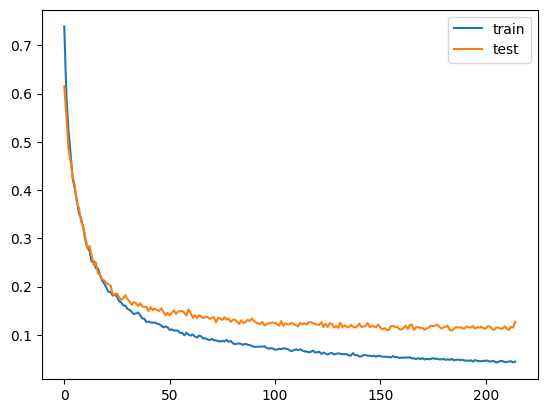

32/32 [==============================] - 2s 2ms/step


C:\Users\marti\AppData\Local\Temp\ipykernel_4420\2116353626.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(resultado_parcial,


In [11]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10)
mae = []
mse = []
rmse = []
me = []

X_cv = X
y_cv = y

for idx, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
    if idx == 6:
        X_train_va, X_test1 = X_cv.iloc[train_idx], X_cv.iloc[test_idx]
        y_train_va, y_test1 = y_cv.iloc[train_idx], y_cv.iloc[test_idx]
        X_train, X_val, y_train, y_val = train_test_split(X_train_va, y_train_va, test_size=0.1, random_state=1)

        
        columns_x = list(X_train.columns)
        scaler_x = StandardScaler()
        X_train_std = X_train.copy()
        X_train_std[columns_x] = scaler_x.fit_transform(X_train[columns_x])
        X_test1_std = X_test1.copy()
        X_test1_std[columns_x] = scaler_x.transform(X_test1[columns_x])
        X_val_std = X_val.copy()
        X_val_std[columns_x] = scaler_x.transform(X_val[columns_x])

        columns_y = list(y_train.columns)
        scaler_y = StandardScaler()
        y_train_std = y_train.copy()
        y_train_std[columns_y] = scaler_y.fit_transform(y_train[columns_y])
        y_test1_std = y_test1.copy()
        y_test1_std[columns_y] = scaler_y.transform(y_test1[columns_y])
        y_val_std = y_val.copy()
        y_val_std[columns_y] = scaler_y.transform(y_val[columns_y])
    
        # reshape input to be 3D [samples, timesteps, features]
        X_train_red = X_train_std.to_numpy().reshape((X_train_std.shape[0], 1, X_train_std.shape[1]))
        X_test1_red = X_test1_std.to_numpy().reshape((X_test1_std.shape[0], 1, X_test1_std.shape[1]))
        X_val_red = X_val_std.to_numpy().reshape((X_val_std.shape[0], 1, X_val_std.shape[1]))

        y_train_red=y_train_std.to_numpy()
        y_test1_red = y_test1_std.to_numpy()
        y_val_red=y_val_std.to_numpy()

        es=0
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30,restore_best_weights=True)

        # regressor = Sequential()
        # regressor.add(GRU(units = 200,return_sequences=True,  input_shape=(X_train_red.shape[1], X_train_red.shape[2])))
        # regressor.add(Dropout(0.3))

        # regressor.add(GRU(units = 100,return_sequences=True))
        # regressor.add(Dropout(0.3))

        # regressor.add(GRU(units = 100))
        # regressor.add(Dropout(0.3))

        # regressor.add(Dense(units = 1, activation = 'linear'))

        # Modelo
        regressor = Sequential()
        regressor.add(LSTM(units = 200, return_sequences = True,  input_shape=(X_train_red.shape[1], X_train_red.shape[2])))
        regressor.add(Dropout(0.3))

        regressor.add(LSTM(units = 100, return_sequences = True))
        regressor.add(Dropout(0.3))

        regressor.add(LSTM(units = 100, return_sequences = True))
        regressor.add(Dropout(0.3))

        regressor.add(LSTM(units = 100))
        regressor.add(Dropout(0.3))

        regressor.add(Dense(units = 1, activation = 'linear'))

        regressor.compile(optimizer = keras.optimizers.Adam(1e-3), loss = 'mean_squared_error', 
                        metrics = ['mean_squared_error'])

        history2 = regressor.fit(X_train_red, y_train_red, epochs=300, batch_size=64, validation_data=(X_val_red, y_val_red), verbose=2, shuffle=False, callbacks=[es])
        
        plt.plot(history2.history['loss'], label='train')
        plt.plot(history2.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        history_df = pd.DataFrame({'train_loss':history2.history['loss'], 'val_loss':history2.history['val_loss']})
        history_df.to_csv("history_kfold_gab.csv")

        # make a prediction
        yhat = regressor.predict(X_test1_red)
        # # invert scaling for forecast
        inv_yhat = scaler_y.inverse_transform(yhat)
        inv_yhat = inv_yhat[:,0]
        # # # invert scaling for actual
        test_y = y_test1_red.reshape((len(y_test1_red), 1))
        inv_y = scaler_y.inverse_transform(test_y)
        inv_y = inv_y[:,0]

        resultado_parcial = {"Modelo":"LSTM_Kfold",
        "median_absolute_error":median_absolute_error(inv_y,inv_yhat),
        "mean_squared_error":mean_squared_error(inv_y,inv_yhat, squared=True),
        "root_mean_squared_error":mean_squared_error(inv_y,inv_yhat, squared=False),
        "max_error":max_error(inv_y,inv_yhat)
        }

        results=results.append(resultado_parcial, 
                    ignore_index = True)

        results.head()

        break
    
    else:
        pass

In [12]:
results

,Modelo,median_absolute_error,mean_squared_error,root_mean_squared_error,max_error
0,LSTM_StratifiedSplit,1.451386,10.664720,3.265688,24.570600
1,LSTM_Kfold,3.380133,57.349317,7.572933,38.429373


In [13]:
# results

# Time series split

Epoch 1/300
9/9 - 6s - loss: 0.9959 - mean_squared_error: 0.9959 - val_loss: 1.0933 - val_mean_squared_error: 1.0933 - 6s/epoch - 654ms/step
Epoch 2/300
9/9 - 0s - loss: 0.9617 - mean_squared_error: 0.9617 - val_loss: 1.0367 - val_mean_squared_error: 1.0367 - 86ms/epoch - 10ms/step
Epoch 3/300
9/9 - 0s - loss: 0.8175 - mean_squared_error: 0.8175 - val_loss: 0.9220 - val_mean_squared_error: 0.9220 - 85ms/epoch - 9ms/step
Epoch 4/300
9/9 - 0s - loss: 0.6604 - mean_squared_error: 0.6604 - val_loss: 0.8901 - val_mean_squared_error: 0.8901 - 88ms/epoch - 10ms/step
Epoch 5/300
9/9 - 0s - loss: 0.5592 - mean_squared_error: 0.5592 - val_loss: 0.7688 - val_mean_squared_error: 0.7688 - 88ms/epoch - 10ms/step
Epoch 6/300
9/9 - 0s - loss: 0.4781 - mean_squared_error: 0.4781 - val_loss: 0.7194 - val_mean_squared_error: 0.7194 - 85ms/epoch - 9ms/step
Epoch 7/300
9/9 - 0s - loss: 0.4217 - mean_squared_error: 0.4217 - val_loss: 0.7014 - val_mean_squared_error: 0.7014 - 87ms/epoch - 10ms/step
Epoch 8/3

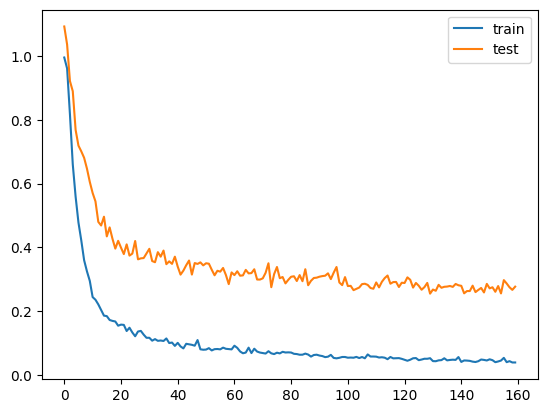

32/32 [==============================] - 1s 2ms/step


C:\Users\marti\AppData\Local\Temp\ipykernel_4420\3193556248.py:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(resultado_parcial,


In [14]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=15)

X_cv = X
y_cv = y

for idx, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
    X_train_va, X_test = X_cv.iloc[train_idx], X_cv.iloc[test_idx]
    y_train_va, y_test = y_cv.iloc[train_idx], y_cv.iloc[test_idx]
    X_train, X_val, y_train, y_val = train_test_split(X_train_va, y_train_va, test_size=0.1, random_state=1)

    
    columns_x = list(X_train.columns)
    scaler_x = StandardScaler()
    X_train_std = X_train.copy()
    X_train_std[columns_x] = scaler_x.fit_transform(X_train[columns_x])
    X_test1_std = X_test1.copy()
    X_test1_std[columns_x] = scaler_x.transform(X_test1[columns_x])
    X_val_std = X_val.copy()
    X_val_std[columns_x] = scaler_x.transform(X_val[columns_x])

    columns_y = list(y_train.columns)
    scaler_y = StandardScaler()
    y_train_std = y_train.copy()
    y_train_std[columns_y] = scaler_y.fit_transform(y_train[columns_y])
    y_test1_std = y_test1.copy()
    y_test1_std[columns_y] = scaler_y.transform(y_test1[columns_y])
    y_val_std = y_val.copy()
    y_val_std[columns_y] = scaler_y.transform(y_val[columns_y])
  
    # reshape input to be 3D [samples, timesteps, features]
    X_train_red = X_train_std.to_numpy().reshape((X_train_std.shape[0], 1, X_train_std.shape[1]))
    X_test1_red = X_test1_std.to_numpy().reshape((X_test1_std.shape[0], 1, X_test1_std.shape[1]))
    X_val_red = X_val_std.to_numpy().reshape((X_val_std.shape[0], 1, X_val_std.shape[1]))

    y_train_red=y_train_std.to_numpy()
    y_test1_red = y_test1_std.to_numpy()
    y_val_red=y_val_std.to_numpy()

    es = 0
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30,restore_best_weights=True)

    # Modelo
    regressor = Sequential()
    regressor.add(LSTM(units = 200, return_sequences = True,  input_shape=(X_train_red.shape[1], X_train_red.shape[2])))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units = 100, return_sequences = True))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units = 100, return_sequences = True))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units = 100))
    regressor.add(Dropout(0.3))

    regressor.add(Dense(units = 1, activation = 'linear'))

    regressor.compile(optimizer = keras.optimizers.Adam(1e-3), loss = 'mean_squared_error', 
                    metrics = ['mean_squared_error'])

    history2 = regressor.fit(X_train_red, y_train_red, epochs=300, batch_size=64, validation_data=(X_val_red, y_val_red), verbose=2, shuffle=False, callbacks=[es])
    
    plt.plot(history2.history['loss'], label='train')
    plt.plot(history2.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    history_df = pd.DataFrame({'train_loss':history2.history['loss'], 'val_loss':history2.history['val_loss']})
    history_df.to_csv("history_ts_gab.csv")

    # make a prediction
    yhat = regressor.predict(X_test1_red)
    # # invert scaling for forecast
    inv_yhat = scaler_y.inverse_transform(yhat)
    inv_yhat = inv_yhat[:,0]
    # # # invert scaling for actual
    test_y = y_test1_red.reshape((len(y_test1_red), 1))
    inv_y = scaler_y.inverse_transform(test_y)
    inv_y = inv_y[:,0]

    resultado_parcial = {"Modelo":"LSTM_TS",
    "median_absolute_error":median_absolute_error(inv_y,inv_yhat),
    "mean_squared_error":mean_squared_error(inv_y,inv_yhat, squared=True),
    "root_mean_squared_error":mean_squared_error(inv_y,inv_yhat, squared=False),
    "max_error":max_error(inv_y,inv_yhat)
    }

    results=results.append(resultado_parcial, 
                ignore_index = True)

    results.head()

    break

In [15]:
results

,Modelo,median_absolute_error,mean_squared_error,root_mean_squared_error,max_error
0,LSTM_StratifiedSplit,1.451386,10.664720,3.265688,24.570600
1,LSTM_Kfold,3.380133,57.349317,7.572933,38.429373
2,LSTM_TS,3.840688,58.334232,7.637685,33.546619
